In [1]:
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
import torch
from torchvision import models, transforms as T, datasets
from cvlib.object_detection import draw_bbox
import torchvision
# from automold import add_rain, add_snow, add_fog
import clip
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
import sys
import os
sys.path.append('..')

2022-02-08 23:14:03.844236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cmlscratch/sriramb/anaconda3/envs/robustlsm/lib/python3.7/site-packages/cv2/../../lib64:
2022-02-08 23:14:03.844272: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

def flatten(lol):
    all_l = []
    for l in lol:
        all_l.extend(l)
    return all_l

In [3]:
import spacy
import deplacy

en = spacy.load('en_core_web_sm')

def get_sentence_frags(text):
    frags = []
    for tok in en(text):
        if tok.dep_ == 'prep':
            frags.append(' '.join([str(w) for w in tok.subtree]))
    return frags

def drop_frags(text):
    frags = get_sentence_frags(text)
    tr_texts = [text]
    tr_texts.extend([text.replace(frag, '') for frag in frags])
    tr_texts = [t for t in tr_texts if len(t)/len(text) > 0.4]
    return tr_texts

In [4]:
drop_frags('A man working on his laptop while a woman reads something on his desk and another eats in the background in the rain')

['A man working on his laptop while a woman reads something on his desk and another eats in the background in the rain',
 'A man working  while a woman reads something on his desk and another eats in the background in the rain',
 'A man working on his laptop while a woman reads something  another eats in the background in the rain',
 'A man working on his laptop while a woman reads something on his desk and another eats ',
 'A man working on his laptop while a woman reads something on his desk and another eats in the background ']

In [6]:
import builtins
def indent(f):
    def closure(*args):
        old = builtins.print
        builtins.print = lambda x, *args, **kwargs:  old("\t>", x, *args, **kwargs)
        a = f(*args)
        builtins.print = old
        return a
    return closure

In [7]:
BICUBIC = torchvision.transforms.functional.InterpolationMode('bicubic')
def size_info_1(x):
    print("1", x)
    return x
def size_info_2(x):
    print("2", x)
    return x
transform = T.Compose([
                    T.Resize(224, interpolation=BICUBIC, max_size=None, antialias=None),
#                     size_info_1,
                    T.CenterCrop(size=(224, 224)),
#                     size_info_2,
                    T.ToTensor()
                    ])
train_cap = datasets.CocoCaptions(root = '/fs/cml-datasets/coco/images/train2017',
                        annFile = '/fs/cml-datasets/coco/annotations/captions_train2017.json',
                        transform=transform
                        )#)
test_cap = datasets.CocoCaptions(root = '/fs/cml-datasets/coco/images/val2017',
                        annFile = '/fs/cml-datasets/coco/annotations/captions_val2017.json',
                        transform=transform
                        )#)

batch_size=128
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_cap, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_cap, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

loading annotations into memory...
Done (t=1.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [8]:
for imgs, texts in test_loader:
    imgs = torch.stack(imgs)
    texts = [t[0] for t in texts]
    break

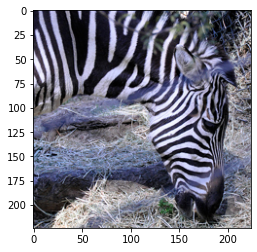

In [21]:
plt.imshow(imgs[74].permute(1,2,0))

In [20]:
texts.index('A zebra grazing on dry hay next to a wire fence.')

74

In [22]:
texts

['People standing in a field and flying kites.',
 'A male Tennis player is trying to secure the ball. ',
 'A little baby sitting on the floor with a cell phone.',
 'A group of people riding waves in the ocean.',
 'A bathroom filled with toilets and a tub next to a sink.',
 'A young man is working behind a counter. ',
 'A flag is flying in a green grassy area.',
 'A man surfing beside a bird on a cloudy day',
 'The Big Ben clock tower towering over the city of London.',
 'People walking by a building with a unique drainpipe.',
 'a man playing tennis going for a low ball',
 'a living room that has some couches and tables in it',
 'A table topped with a laptop computer next to a plate of food.',
 'Two men playing a game of tennis on a court.',
 'A computer keyboard sitting next to a mouse.',
 'A young boy standing on a field next to a giraffe.',
 'GUY WITH UMBRELLA HAT SITTING A TABLE WITH ANOTHER PERSON',
 'A blue, yellow and green surfboard sticking out of a sandy beach.',
 'In a large 

In [20]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [49]:
def sim(model, imgs, texts):
    with torch.no_grad():
        normalize = T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
        text_tokens = clip.tokenize(texts).to(device)
#         processed_imgs = torch.stack([normalize(img).to(device) for img in imgs])    
        imgs = normalize(imgs).to(device)
        similarities, _ = model(imgs, text_tokens)
    return similarities.detach().cpu()

In [42]:
class EnsembleCLIP(torch.nn.Module):
    def __init__(self, model, preprocess, device):
        super(EnsembleCLIP, self).__init__()
        self.model = model
        self.device = torch.device(device)
        self.normalize = T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))

    def forward(self, imgs, texts):
        tr_texts = [drop_frags(t) for t in texts]       
        print(tr_texts[:3])
        num_samples = [len(t) for t in tr_texts]
        tr_texts = ["a photo of "+t for t in flatten(tr_texts)]
        
        with torch.no_grad():
            text_tokens = clip.tokenize(tr_texts).to(self.device)
    #         processed_imgs = torch.stack([normalize(img).to(device) for img in imgs])    
            imgs = self.normalize(imgs).to(device)
            similarities, _ = model(imgs, text_tokens)
        similarities = torch.split(similarities,num_samples,dim=1)
        similarities = torch.stack([a.mean(-1) for a in similarities], dim=-1)
        print(similarities.shape)
        return similarities.detach().cpu()

In [46]:
class NormalCLIP(torch.nn.Module):
    def __init__(self, model, preprocess, device):
        super(NormalCLIP, self).__init__()
        self.model = model
        self.device = torch.device(device)
        self.normalize = T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))

    def forward(self, imgs, texts):
        texts = ["a photo of "+t for t in texts]
        with torch.no_grad():
            text_tokens = clip.tokenize(texts).to(device)
    #         processed_imgs = torch.stack([normalize(img).to(device) for img in imgs])    
            imgs = self.normalize(imgs).to(self.device)
            similarities, _ = model(imgs, text_tokens)
        return similarities.detach().cpu()

In [39]:
def test(models, names):
    for imgs, texts in test_loader:
        imgs = torch.stack(imgs)
        texts = [t[0] for t in texts]
        for model, name in zip(models, names):
            a = model(imgs, texts)
            print(f"Clean accuracy {name}: ",float((a.argmax(-1) == torch.arange(batch_size)).float().mean()))
        print('\n')
    return

In [44]:
ensemble_clip = EnsembleCLIP(model, preprocess, device)
normal_clip = NormalCLIP(model, preprocess, device)

In [47]:
test([normal_clip, ensemble_clip],  ['normal', 'ensemble'])

Clean accuracy normal:  0.78125
[['a large air plane flying thru the air', 'a large air plane flying '], ['A man riding a skateboard up a flight of steps.', 'A man riding a skateboard up a flight .'], ['a banana is laying on a small plate', 'a banana is laying ']]
torch.Size([128, 128])
Clean accuracy ensemble:  0.7578125


Clean accuracy normal:  0.7890625
[['Baseball team holding batting practice on the field', 'Baseball team holding batting practice '], ['A crowded kitchen that is cluttered and messy.'], ['The woman holding an umbrella smiles on the narrow street beside the sidewalk.', 'The woman holding an umbrella smiles .', 'The woman holding an umbrella smiles on the narrow street .']]
torch.Size([128, 128])
Clean accuracy ensemble:  0.796875


Clean accuracy normal:  0.765625
[['A white meta bench next to a patch of grass.', 'A white meta bench next .', 'A white meta bench next to a patch .'], ['A group of people is standing outside of a tram.', 'A group  is standing outside of

torch.Size([128, 128])
Clean accuracy ensemble:  0.7890625


Clean accuracy normal:  0.796875
[['a white dog is sitting in the back of a truck and a mattress', 'a white dog is sitting in the back  and a mattress'], ['A group of people looking at some kind of show or exhibit ', 'A group of people looking  ', 'A group of people looking at some kind  '], ['Large assortment of small and large vases displayed outdoors.', 'Large assortment  displayed outdoors.']]
torch.Size([128, 128])
Clean accuracy ensemble:  0.8046875


Clean accuracy normal:  0.8359375
[['The side of a bus parked on the side of a street.', 'The side of a bus parked .', 'The side of a bus parked on the side .'], ['A man in a wet suit stands on a surfboard and rows with a paddle.', 'A man  stands on a surfboard and rows with a paddle.', 'A man in a wet suit stands  and rows with a paddle.', 'A man in a wet suit stands on a surfboard and rows .'], ['A kitchen has wooden cabinets and black countertops.']]
torch.Size([128, 12

KeyboardInterrupt: 

In [7]:
# text detection
def style_text_detect(text, style):
    pass

In [8]:
# text transformations

def style_text_transform(text, style):
    pass



In [9]:
# image detection
def style_image_detect(text, style):
    pass

def clarity_image_detect(text, style):
    pass


In [10]:
# image transformations
def style_image_transform(image, style):
    pass

def blur_image_transform(image, blur):
    return cv2.blur(img,(blur,blur))

def object_resize_image_transform(image, obj):
    pass


In [11]:
# fog_mask = create_fog([ 100 , 100], [20, 100], np.zeros((224, 224)))
# fog_mask = create_fog([ 150 , 150], [40, 90], fog_mask)
# fog_mask = create_fog([ 200 , 200], [30, 80], fog_mask)
# fog_mask = create_fog([ 200 , 100], [20, 70], fog_mask)
# fog_mask = create_fog([ 25 , 150], [40, 90], fog_mask)
# fog_mask = create_fog([ 50 , 50], [20, 20], fog_mask)

# fog_mask = np.expand_dims(fog_mask, axis=-1).astype(np.float32)
# fog_mask = fog_mask/fog_mask.max()
# orig_img = (imgs[0].permute((1,2,0)).numpy()).astype(np.float32)#

# # orig_img[orig_img > 1] = 1
# print(orig_img.max(), orig_img.shape, orig_img.dtype)
# hsv = cv2.cvtColor(orig_img, cv2.COLOR_RGB2HSV)
# hsv[:,:,1:2] = hsv[:,:,1:2]*(1 - fog_mask)
# hsv[:,:,2:3] = hsv[:,:,2:3]*(1 - fog_mask) + fog_mask
# hsv[:,:,2] *= 0.6
# rgb_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
# plt.imshow(rgb_img)

In [53]:
def create_fog(mean, std, arr):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            arr[i][j] += np.exp(-((i-mean[0])**2/(2*std[0]**2) + (j-mean[1])**2/(2*std[1]**2)))
    return arr

fog_mask = create_fog([ 100 , 100], [20, 100], np.zeros((224, 224)))
fog_mask = create_fog([ 150 , 150], [40, 90], fog_mask)
fog_mask = create_fog([ 200 , 200], [30, 80], fog_mask)
fog_mask = create_fog([ 200 , 100], [20, 70], fog_mask)
fog_mask = create_fog([ 25 , 150], [40, 90], fog_mask)
fog_mask = create_fog([ 50 , 50], [20, 20], fog_mask)

fog_mask = np.expand_dims(fog_mask, axis=-1).astype(np.float32)
fog_mask = fog_mask/fog_mask.max()


def add_fog(orig_img):
    #     orig_img = (imgs[0].permute((1,2,0)).numpy()).astype(np.float32)#

    # orig_img[orig_img > 1] = 1
    hsv = cv2.cvtColor(orig_img, cv2.COLOR_RGB2HSV)
    hsv[:,:,1:2] = hsv[:,:,1:2]*(1 - fog_mask)
    hsv[:,:,2:3] = hsv[:,:,2:3]*(1 - fog_mask) + fog_mask
    hsv[:,:,2] *= 0.6
    rgb_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb_img

err_rain_slant="Numeric value between -20 and 20 is allowed"
err_rain_width="Width value between 1 and 5 is allowed"
err_rain_length="Length value between 0 and 100 is allowed"

def generate_random_lines(imshape,slant,drop_length,rain_type):
    drops=[]
    area=imshape[0]*imshape[1]
    no_of_drops=area//600

    if rain_type.lower()=='drizzle':
        no_of_drops=area//770
        drop_length=10
    elif rain_type.lower()=='heavy':
        drop_length=30
    elif rain_type.lower()=='torrential':
        no_of_drops=area//500
        drop_length=60

    for i in range(no_of_drops): ## If You want heavy rain, try increasing this
        if slant<0:
            x= np.random.randint(slant,imshape[1])
        else:
            x= np.random.randint(0,imshape[1]-slant)
        y= np.random.randint(0,imshape[0]-drop_length)
        drops.append((x,y))
    return drops,drop_length

def rain_process(image,slant,drop_length,drop_color,drop_width,rain_drops):
    imshape = image.shape  
    image_t= image.copy()
    for rain_drop in rain_drops:
        cv2.line(image_t,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),(0.8, 0.8, 0.8),drop_width)
    image= cv2.blur(image_t,(3,3)) ## rainy view are blurry
    brightness_coefficient = 0.8 ## rainy days are usually shady 
    image_HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HSV[:,:,1] = image_HSV[:,:,1]*0.8 ## scale pixel values down for channel 1(Lightness)
    image_RGB= cv2.cvtColor(image_HSV, cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

##rain_type='drizzle','heavy','torrential'
def add_rain(image,slant=20,drop_length=20,drop_width=1,drop_color=(200,200,200),rain_type='heavy'): ## (200,200,200) a shade of gray
    slant_extreme=slant
    imshape = image.shape
    if slant_extreme==-1:
        slant= np.random.randint(-10,10) ##generate random slant if no slant value is given
    rain_drops,drop_length= generate_random_lines(imshape,slant,drop_length,rain_type)
    image_RGB = rain_process(image,slant_extreme,drop_length,drop_color,drop_width,rain_drops)
    return image_RGB

In [52]:
def weather_detect(img, text):
    tokens = word_tokenize(text)
    vec = [0,0,0]
#     if 'rain' in tokens or 'rainy' in tokens:
#         vec[0] = 1
#     if 'snow' in tokens or 'snowy' in tokens:
#         vec[1] = 1
#     if 'rain' in tokens or 'rainy' in tokens:
#         vec[2] = 1
    noun_dict = {'rain': 0, 'snow':1, 'fog':2}
    adj_dict = {'rainy': 0, 'snowy':1, 'foggy':2}
    for i in range(len(tokens)):
        if tokens[i] in noun_dict.keys():
            vec[noun_dict[tokens[i]]] = 1
            tokens[i] = '[NOUN]'
        if tokens[i] in adj_dict.keys():
            vec[adj_dict[tokens[i]]] = 1
            tokens[i] = '[ADJ]'
    return vec, ' '.join(tokens)

def weather_detect_both(img, text):
    return sum(weather_detect(img, text)[0]) == 0

import time
def weather_transform_both(img, text):
    numpy_image = img.permute(1,2,0).numpy().astype(np.float32)
    a = time.time()
    image_rainy = torch.Tensor(add_rain(numpy_image)).permute(2,0,1)
    a = time.time()
    image_foggy = torch.Tensor(add_fog(numpy_image)).permute(2,0,1)
    image_rainy = image_rainy.clamp(0,1)
    image_foggy = image_foggy.clamp(0,1)
#     plt.imsave('./examples/transformed_rainy_'+text+'.png', image_rainy.permute(1,2,0).numpy())
#     plt.imsave('./examples/transformed_snowy_'+text+'.png', image_snowy.permute(1,2,0).numpy())
#     plt.imsave('./examples/transformed_foggy_'+text+'.png', image_foggy.permute(1,2,0).numpy())
    tr_imgs = torch.stack([image_rainy, image_foggy])
    tr_text = ["a photo of " + text[:1].lower() + text[1:].strip('.') + ' in the ' + w for w in ['rain', 'fog']]
    return tr_text, tr_imgs

In [14]:
# img = (imgs[1].permute((1,2,0)).numpy()*255).astype(int)
# img = cv2.imread("examples/transformed_foggy_A little girl holding wet broccoli in her hand. .png")
# image_HLS = cv2.cvtColor(img.astype(np.float32)/255,cv2.COLOR_RGB2HLS) ## Conversion to HLS
# image_HLS = np.array(image_HLS, dtype = np.float64) 
#     brightness_coefficient = 1.2
#     imshape = image.shape
#     snow_point=snow_coeff ## increase this for more snow
#     image_HLS[:,:,1][image_HLS[:,:,1]<snow_point] = image_HLS[:,:,1][image_HLS[:,:,1]<snow_point]*brightness_coefficient ## scale pixel values up for channel 1(Lightness)
#     image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
# image_HLS = np.array(image_HLS, dtype = np.uint8)
# image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB)

In [51]:
def transform_both(imgs, texts , transform_fn, detect_fn):
    rel_imgs = []
    rel_texts = []
    for img, text in zip(imgs, texts):
        if detect_fn(img, text):
            tr_texts, tr_imgs = transform_fn(img, text)
            rel_imgs.append(tr_imgs)
            rel_texts.append(tr_texts)
    rel_imgs = torch.stack(rel_imgs)
#     rel_texts = flatten(rel_texts)
    return rel_imgs, rel_texts


@indent
def test_on_transformed_both(model, tr_imgs, tr_texts):
    dim_size = len(tr_imgs[0])
    flat_texts = flatten(tr_texts)
    flat_imgs = tr_imgs.reshape(-1, *tr_imgs.shape[2:])
    sims = sim(model, flat_imgs, flat_texts)
    preds = sims.argmax(-1)
    gt = torch.arange(len(flat_imgs))
    gen_preds = torch.div(preds, dim_size, rounding_mode='floor')
    gen_gt = torch.div(gt, dim_size, rounding_mode='floor')
    gen_preds_2 = preds % dim_size
    gen_gt_2 = gt % dim_size
    print("Reduced probability (across samples): ", float((gen_preds == gen_gt).float().mean()))
    print("Reduced probability (across pert dimension): ", float((gen_preds_2 == gen_gt_2).float().mean()))
    print("Average dimension specific probability: ", float((preds == gt).float().mean()))
#     preds = preds.reshape(-1, dim_size)
#     gt = gt.reshape(-1, dim_size)
#     print("Probability for dim 0: ", float((preds[:,0] == gt[:,0]).float().mean()))
#     print("Probability for dim 1: ", float((preds[:,1] == gt[:,1]).float().mean()))
    return preds, gt



In [16]:
print(torch.arange(10)%2)

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])


In [55]:
all_tr_imgs, all_tr_texts = [], []
detect_fn = lambda a, b : True
b = 0
for imgs, texts in test_loader:
    imgs = torch.stack(imgs)
    texts = [t[0] for t in texts]
#     print(imgs.shape, len(texts))
    a = sim(model, imgs, ["a photo of "+t for t in texts])
    print("Clean accuracy: ",float((a.argmax(-1) == torch.arange(batch_size)).float().mean()))
    tr_imgs, tr_texts = transform_both(imgs, texts, weather_transform_both, detect_fn)
    sample_texts = [["a photo of "+t for _ in range(2)] for t in texts]
    dim_texts = [["a photo of rain", "a photo of fog"] for _ in range(len(texts))]
    print("Combined acc:")
    preds, gt = test_on_transformed_both(model, tr_imgs, tr_texts)
    print("Sample text probes acc:")
    preds_1, gt_1 = test_on_transformed_both(model, tr_imgs, sample_texts)
    print("Dimension text probes acc")
    preds_2, gt_2 = test_on_transformed_both(model, tr_imgs, dim_texts)
    
    dim_size = len(tr_imgs[0])
    gen_preds_1 = torch.div(preds_1, dim_size, rounding_mode='floor')
    gen_gt_1 = torch.div(gt_1, dim_size, rounding_mode='floor')
    gen_preds_2 = preds_2 % dim_size
    gen_gt_2 = gt_2 % dim_size
    print("Individual text probes acc multiplied:", float(np.logical_and(gen_preds_1 == gen_gt_1 , gen_preds_2 == gen_gt_2).float().mean()))

    all_tr_imgs.append(tr_imgs)
    all_tr_texts.append(tr_texts)
    print("\n")
    

	> Clean accuracy:  0.7734375
	> Combined acc:
	> 	> Reduced probability (across samples):  0.62890625
	> 	> Reduced probability (across pert dimension):  0.8125
	> 	> Average dimension specific probability:  0.4921875
	> Sample text probes acc:
	> 	> Reduced probability (across samples):  0.6640625
	> 	> Reduced probability (across pert dimension):  0.5
	> 	> Average dimension specific probability:  0.30859375
	> Dimension text probes acc
	> 	> Reduced probability (across samples):  0.0078125
	> 	> Reduced probability (across pert dimension):  0.71875
	> 	> Average dimension specific probability:  0.0078125
	> Individual text probes acc multiplied: 0.47265625
	> 

	> Clean accuracy:  0.7734375
	> Combined acc:
	> 	> Reduced probability (across samples):  0.69921875
	> 	> Reduced probability (across pert dimension):  0.80078125
	> 	> Average dimension specific probability:  0.55859375
	> Sample text probes acc:
	> 	> Reduced probability (across samples):  0.67578125
	> 	> Reduced proba

	> 	> Reduced probability (across samples):  0.7734375
	> 	> Reduced probability (across pert dimension):  0.5
	> 	> Average dimension specific probability:  0.3671875
	> Dimension text probes acc
	> 	> Reduced probability (across samples):  0.0078125
	> 	> Reduced probability (across pert dimension):  0.71875
	> 	> Average dimension specific probability:  0.00390625
	> Individual text probes acc multiplied: 0.54296875
	> 

	> Clean accuracy:  0.8359375
	> Combined acc:
	> 	> Reduced probability (across samples):  0.7265625
	> 	> Reduced probability (across pert dimension):  0.80859375
	> 	> Average dimension specific probability:  0.60546875
	> Sample text probes acc:
	> 	> Reduced probability (across samples):  0.7265625
	> 	> Reduced probability (across pert dimension):  0.5
	> 	> Average dimension specific probability:  0.34765625
	> Dimension text probes acc
	> 	> Reduced probability (across samples):  0.0078125
	> 	> Reduced probability (across pert dimension):  0.74609375
	> 	> 

KeyboardInterrupt: 

In [16]:
weather_texts

[['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],
 ['a photo of rain', 'a photo of fog'],


In [19]:
texts

['A cake shaped like a horse with white frosting and decorative candies in different colors.',
 'Racer riding a dirt bike on a race course.',
 'a street sign on a pole on a city street',
 'A baseball glove and ball in a grassy field.',
 'An office with a corner desk full of three desk top computers and paper.',
 'A blue double decker bus driving in front of a green double decker.',
 'Trays of various donuts in a glass case.',
 'a person riding skis on a snowy surface',
 'A sandwich and chips are on a plate with a cup of coffee, cell phone, and a newspaper nearby.',
 'A beach filled with docked boats next to the ocean.',
 'A decorated VW van is used as a display on a wall.',
 'A woman holds a tennis racket and tennis ball.',
 'A parade going on in the street while people on the side watch.',
 'A blue bus in multiple lanes on a city street.',
 'This is one man with two different sides to him.',
 'A bright yellow fire hydrant on the sidewalk by a road.',
 'A graphic of a girl holding skat

In [17]:
tr_texts

[['a photo of A man working on his laptop while a woman reads something on his desk and another eats in the background in the rain',
  'a photo of A man working on his laptop while a woman reads something on his desk and another eats in the background in the fog'],
 ['a photo of two giraffes in a wooded area looking straight at the camera in the rain',
  'a photo of two giraffes in a wooded area looking straight at the camera in the fog'],
 ['a photo of A black cat is sitting in a round blue chair in the rain',
  'a photo of A black cat is sitting in a round blue chair in the fog'],
 ['a photo of A woman laying on top of a bed in red shoes in the rain',
  'a photo of A woman laying on top of a bed in red shoes in the fog'],
 ['a photo of A burned up old outdated computer sitting on a desk in the rain',
  'a photo of A burned up old outdated computer sitting on a desk in the fog'],
 ['a photo of Large group of people all sitting lined up across a large table in the rain',
  'a photo of 

In [12]:
deplacy.render(en('A couple of men standing on a baseball field in uniform.'))


A        DET   <════════════════╗   det
couple   NOUN  ═══════════════╗═╝═╗ ROOT
of       ADP   ═════════════╗<╝   ║ prep
men      NOUN  ═══════════╗<╝     ║ pobj
standing VERB  ═══════╗═╗<╝       ║ acl
on       ADP   ═════╗<╝ ║         ║ prep
a        DET   <══╗ ║   ║         ║ det
baseball NOUN  <╗ ║ ║   ║         ║ compound
field    NOUN  ═╝═╝<╝   ║         ║ pobj
in       ADP   ═╗<══════╝         ║ prep
uniform  NOUN  <╝                 ║ pobj
.        PUNCT <══════════════════╝ punct


In [14]:
deplacy.render(en('A very cute cat laying in a small sink'))


A      DET  <════╗     det
very   ADV  <╗   ║     advmod
cute   ADJ  ═╝<╗ ║     amod
cat    NOUN ═══╝═╝<══╗ nsubj
laying VERB ═══════╗═╝ ROOT
in     ADP  ═════╗<╝   prep
a      DET  <══╗ ║     det
small  ADJ  <╗ ║ ║     amod
sink   NOUN ═╝═╝<╝     pobj


In [ ]:
torch.cuda.empty_cache()

In [ ]:
'The young girl is feeding the young boy.'.strip('.')

In [ ]:
# insert at 1, 0 is the script path (or '' in REPL)
from object_remove_inpaint.src.edge_connect import EdgeConnect
from object_remove_inpaint.src.config import Config

config = Config('../object_remove_inpaint/checkpoints/config.yml')
config.MODE = 2
config.MODEL = 3
config.OBJECTS = None #which objects?
config.SEG_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
config.INPUT_SIZE = 256 #input size